In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv('resources/transactions_2.csv')

df

,time,status,count
0,00h 00,reversed,7
1,00h 00,approved,9
2,00h 00,processing,12
3,00h 00,denied,3
4,00h 00,backend_reversed,2
...,...,...,...
3939,23h 57,denied,11
3940,23h 58,denied,4
3941,23h 58,approved,35
3942,23h 59,denied,10


In [3]:
from prophet import Prophet

df['time'] = pd.to_datetime(df['time'], format='%Hh %M')


train_status = df.loc[(df['status'] == 'reversed') | (df['status'] == 'failed')]
train = train_status.groupby([train_status['time'].dt.hour]).mean()
train = train.reset_index()

train = train[['time', 'count']].rename({'time':'ds', 'count':'y'}, axis='columns')
train['ds'] = pd.to_datetime(train['ds'], format='%H')

/tmp/ipykernel_16517/3928800973.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train = train_status.groupby([train_status['time'].dt.hour]).mean()


In [4]:
train.shape

(23, 2)

In [5]:
train

,ds,y
0,1900-01-01 00:00:00,4.315789
1,1900-01-01 01:00:00,1.000000
2,1900-01-01 02:00:00,1.000000
3,1900-01-01 03:00:00,1.000000
4,1900-01-01 05:00:00,1.000000
5,1900-01-01 06:00:00,1.000000
6,1900-01-01 07:00:00,1.176471
7,1900-01-01 08:00:00,1.533333
8,1900-01-01 09:00:00,2.326531
9,1900-01-01 10:00:00,2.843137


In [6]:
m = Prophet(changepoint_range=0.95)

m.fit(train)

21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=22, freq='H')
future.tail(35)

,ds
10,1900-01-01 11:00:00
11,1900-01-01 12:00:00
12,1900-01-01 13:00:00
13,1900-01-01 14:00:00
14,1900-01-01 15:00:00
15,1900-01-01 16:00:00
16,1900-01-01 17:00:00
17,1900-01-01 18:00:00
18,1900-01-01 19:00:00
19,1900-01-01 20:00:00


In [8]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
40,1900-01-02 17:00:00,3.234650,1.282261,5.181009
41,1900-01-02 18:00:00,3.268903,1.370319,5.188717
42,1900-01-02 19:00:00,3.303156,1.412597,5.157774
43,1900-01-02 20:00:00,3.337410,1.588508,5.089702
44,1900-01-02 21:00:00,3.371663,1.452927,5.388239


In [11]:
results=pd.concat([train.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

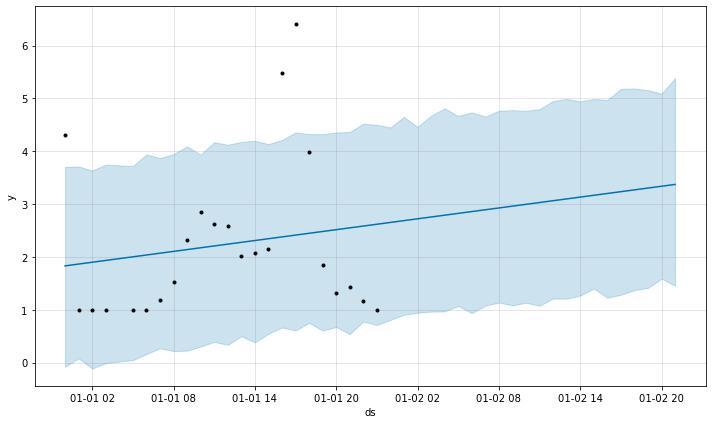

In [12]:
fig1 = m.plot(forecast)